In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import import_ipynb
from UtilDataframes import cvtTimestampIntoDatetimeIndex
from time import time

importing Jupyter notebook from UtilDataframes.ipynb


,Unnamed: 0,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,24096863,1631582460,1,1069.0,45287.741429,45314.95,45268.40,45298.868508,36.800881,45291.343025,-0.000032
1,24096877,1631582520,1,2577.0,45302.568571,45371.46,45294.02,45348.035714,69.452843,45323.250853,0.000480
2,24096891,1631582580,1,1471.0,45349.388571,45374.48,45311.00,45333.891429,43.836552,45348.666794,0.001613
3,24096905,1631582640,1,1480.0,45321.851693,45355.37,45251.30,45277.501429,44.815200,45294.024285,0.001632
4,24096919,1631582700,1,1101.0,45278.460234,45313.59,45249.02,45269.988333,32.039459,45283.350543,0.001293


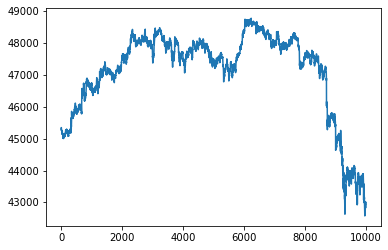

In [2]:
data = pd.read_csv('../data/Market/btc.csv')
data['Close'].plot()
data.head()

In [3]:
btc = data[['timestamp', 'Close']].copy()
btc.dropna(inplace=True)

**Convertimos la columna de timestamps a datetimes y la ponemos como index**

In [4]:
cvtTimestampIntoDatetimeIndex(btc, 'timestamp')
btc

,Close
timestamp,
2021-09-14 03:21:00,45298.868508
2021-09-14 03:22:00,45348.035714
2021-09-14 03:23:00,45333.891429
2021-09-14 03:24:00,45277.501429
2021-09-14 03:25:00,45269.988333
...,...
2021-09-21 01:56:00,42899.012857
2021-09-21 01:57:00,42860.005714
2021-09-21 01:58:00,42827.020000


**Inferimos la frecuencia de los datos, sirve para rellenar algún hueco en el registro de las fechas, por ejemplo que se salte el registro de un minuto de una hora en concreto de un día**

In [5]:
btc = btc.asfreq(pd.infer_freq(btc.index))
btc.head()

,Close
timestamp,
2021-09-14 03:21:00,45298.868508
2021-09-14 03:22:00,45348.035714
2021-09-14 03:23:00,45333.891429
2021-09-14 03:24:00,45277.501429
2021-09-14 03:25:00,45269.988333


**Ahora vamos a ploter la correlación parcial de 100 lags, es decir, la correlación de cada momento t, con los 100 anteriores, uno por uno**

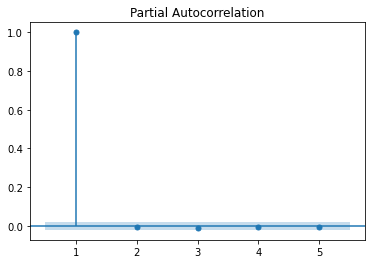

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(btc, lags=5, method='ywm', zero=False); # Se pone el punto y coma para que no se plotee dos veces, son cosas de ipy notebooks

**Parece que hay una correlación fuerte con el período anterior, es decir, de cada periodo t, con t - 1**

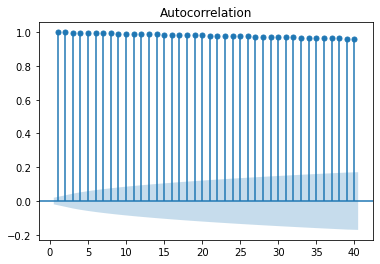

In [7]:
plot_acf(btc, zero=False);

**Parece ser que hay una correlación fuerte con los períodos anteriores**

**Vamos a crear ahora los conjuntos de entrenamiento y de testeo**

In [8]:
train_end_date = datetime(2021, 9, 19)
test_start_date = train_end_date + timedelta(seconds=60)
train_data = btc[:train_end_date]
test_data = btc[test_start_date:]
train_data

,Close
timestamp,
2021-09-14 03:21:00,45298.868508
2021-09-14 03:22:00,45348.035714
2021-09-14 03:23:00,45333.891429
2021-09-14 03:24:00,45277.501429
2021-09-14 03:25:00,45269.988333
...,...
2021-09-18 23:56:00,47880.115823
2021-09-18 23:57:00,47910.905714
2021-09-18 23:58:00,47901.362857


**Vamos a crear el modelo de auto regresión y entrenarlo**

In [9]:
model = ARIMA(train_data, order=(3, 0, 0))
start = time()
fitted_model = model.fit()
end = time()
print(f'Model Successfully Fitted!. Time spent: {end-start}')

Model Successfully Fitted!. Time spent: 16.819249153137207


In [10]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 7000
Model:                ARIMA(15, 0, 0)   Log Likelihood              -33530.437
Date:                Wed, 24 Nov 2021   AIC                          67094.874
Time:                        13:05:17   BIC                          67211.386
Sample:                    09-14-2021   HQIC                         67135.022
                         - 09-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.748e+04    887.081     53.526      0.000    4.57e+04    4.92e+04
ar.L1          0.9986      0.007    144.701      0.000       0.985       1.012
ar.L2          0.0245      0.010      2.458      0.014       0.005       0.044
ar.L3         -0.0124      0.011     -1.119      0.263      -0.034       0.009
ar.L4         -0.0255      0.014     -1.861      0.063      -0.052       0.001
ar.L5          0.0508      0.011      4.614      0.000       0.029       0.072
ar.L6         -0.0650      0.011     -5.886      0.000      -0.087      -0.043
ar.L7         -0.0015      0.013     -0.110      0.913      -0.028       0.025
ar.L8          0.0285      0.015      1.935      0.053      -0.000       0.057
ar.L9         -0.0183      0.015     -1.226      0.220      -0.048       0.011
ar.L10         0.0698      0.015      4.689      0.000       0.041       0.099
ar.L11        -0.0422      0.013     -3.135      0.002      -0.069      -0.016
ar.L12        -0.0372      0.013     -2.885      0.004      -0.063      -0.012
ar.L13         0.0111      0.015      0.748      0.455      -0.018       0.040
ar.L14        -0.0056      0.015     -0.362      0.717      -0.036       0.025
ar.L15         0.0240      0.010      2.415      0.016       0.005       0.044
sigma2       846.5389      5.897    143.565      0.000     834.982     858.096
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             53115.13
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.92e+14. Standard errors may be unstable.
"""

**Vamos a realizar una predicción del modelo para las primeras 5 entradas del dataset de testeo, esto sería como predecir el precio del bitcoin los 5 minutos siguientes**

In [11]:
prediction_start_date = test_data.index[0]
prediction_end_date = test_data.index[19]
print(f"We will do prediction from {prediction_start_date} to {prediction_end_date}")

We will do prediction from 2021-09-19 00:01:00 to 2021-09-19 00:20:00


In [12]:
predictions = fitted_model.predict(start=prediction_start_date, end=prediction_end_date)
residuals = test_data['Close'][:20] - predictions

Text(0.5, 1.0, 'Residuos del Modelo ARMA')

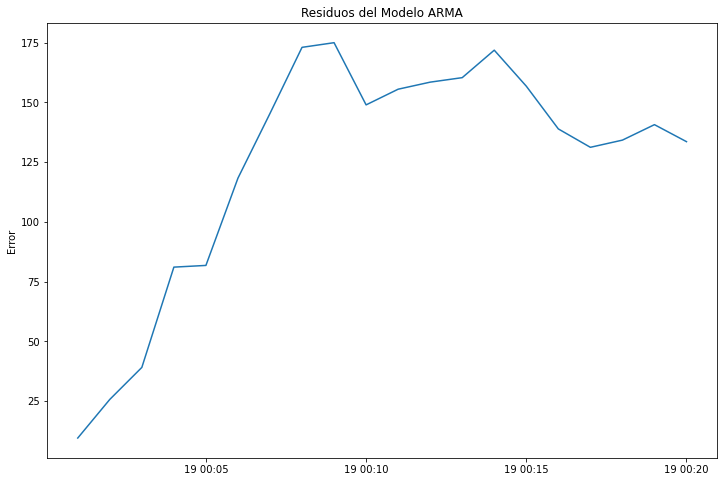

In [13]:
fig = plt.figure(figsize=(12, 8))
plt.plot(residuals)
plt.ylabel("Error")
plt.title("Residuos del Modelo ARMA")

**Podemos observar que el error va aumentando a medida que nos alejamos en el tiempo de los datos de entrenamiento, desde un error menor que 10 (dólares) para el minuto 1, hasta un error de más de 80 en el minuto 5**

**Vamos ahora a plotear el valor real del bitcoin junto con las predicciones que hemos hecho:**

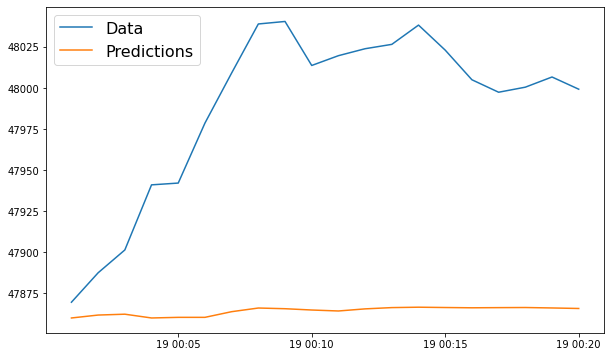

In [14]:
plt.figure(figsize=(10,6))
plt.plot(test_data[:20])
plt.plot(predictions)
plt.legend(('Data', 'Predictions'), fontsize=16)

**Podemos ver que nuestro modelo no captura bien la tendencia alcista del los datos**

**Para entender de forma más precisa cuánto se equivoca nuestro modelo, podemos calcular el porcentaje que representan los residuos sobre el valor real de los datos:**

In [15]:
mean_absolute_percent_error = round(np.mean(abs(residuals/test_data['Close'][:20])), 4)
print(f"De media nos desviamos del valor real un {mean_absolute_percent_error}% con las predicciones realizadas")

De media nos desviamos del valor real un 0.0026% con las predicciones realizadas
